In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [2]:
from conformal_region_designer.case_studies.car_experiments import CarEnvironment, generate_calibration_dataset, generate_train_dataset, TrajectoryPredictor
from conformal_region_designer.utils import set_square_aspect_ratio, shuffle_split_testing

In [3]:
import random
random.seed(42)
np.random.seed(42)
train_X, train_Y = generate_train_dataset(100)
env_X, env_Y = generate_calibration_dataset(10_000)

In [4]:
predictor = TrajectoryPredictor(0.1)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


Text(0.5, 0.98, 'Training Trajectories')

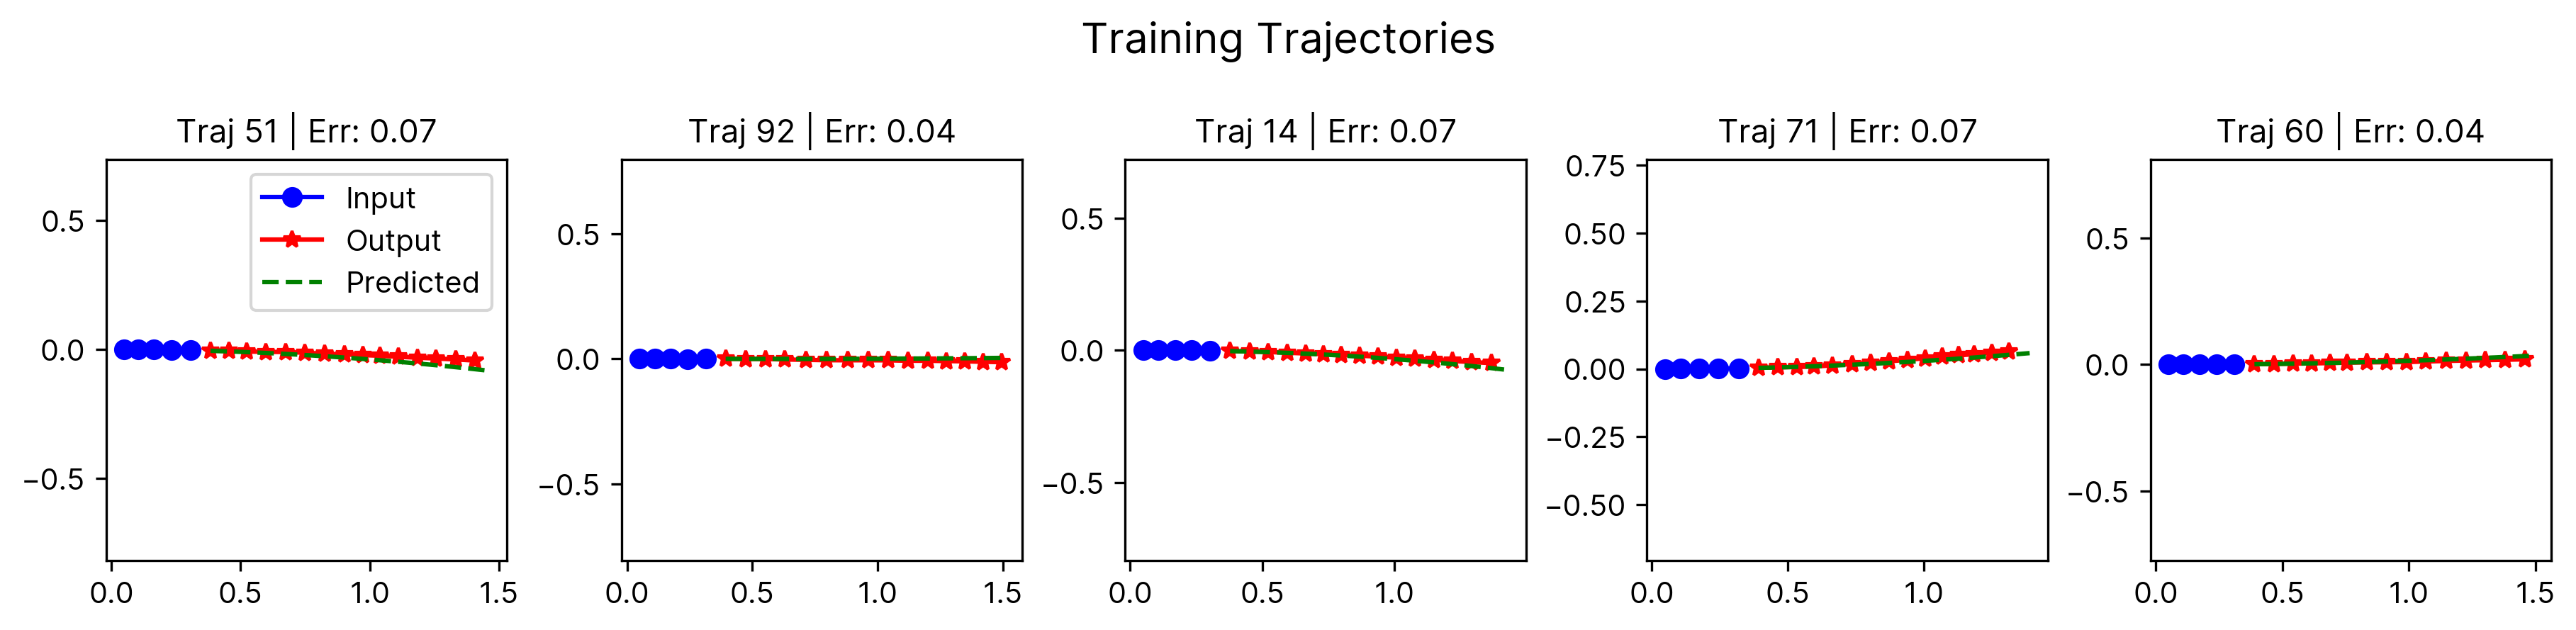

In [5]:
INDEX = np.random.choice(train_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(train_X[INDEX[i], :, 0], train_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(train_Y[INDEX[i], :, 0], train_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(train_X[INDEX[i]])
    error = np.linalg.norm(prediction - train_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
plt.suptitle('Training Trajectories')

Text(0.5, 0.98, 'Calibration Distribution')

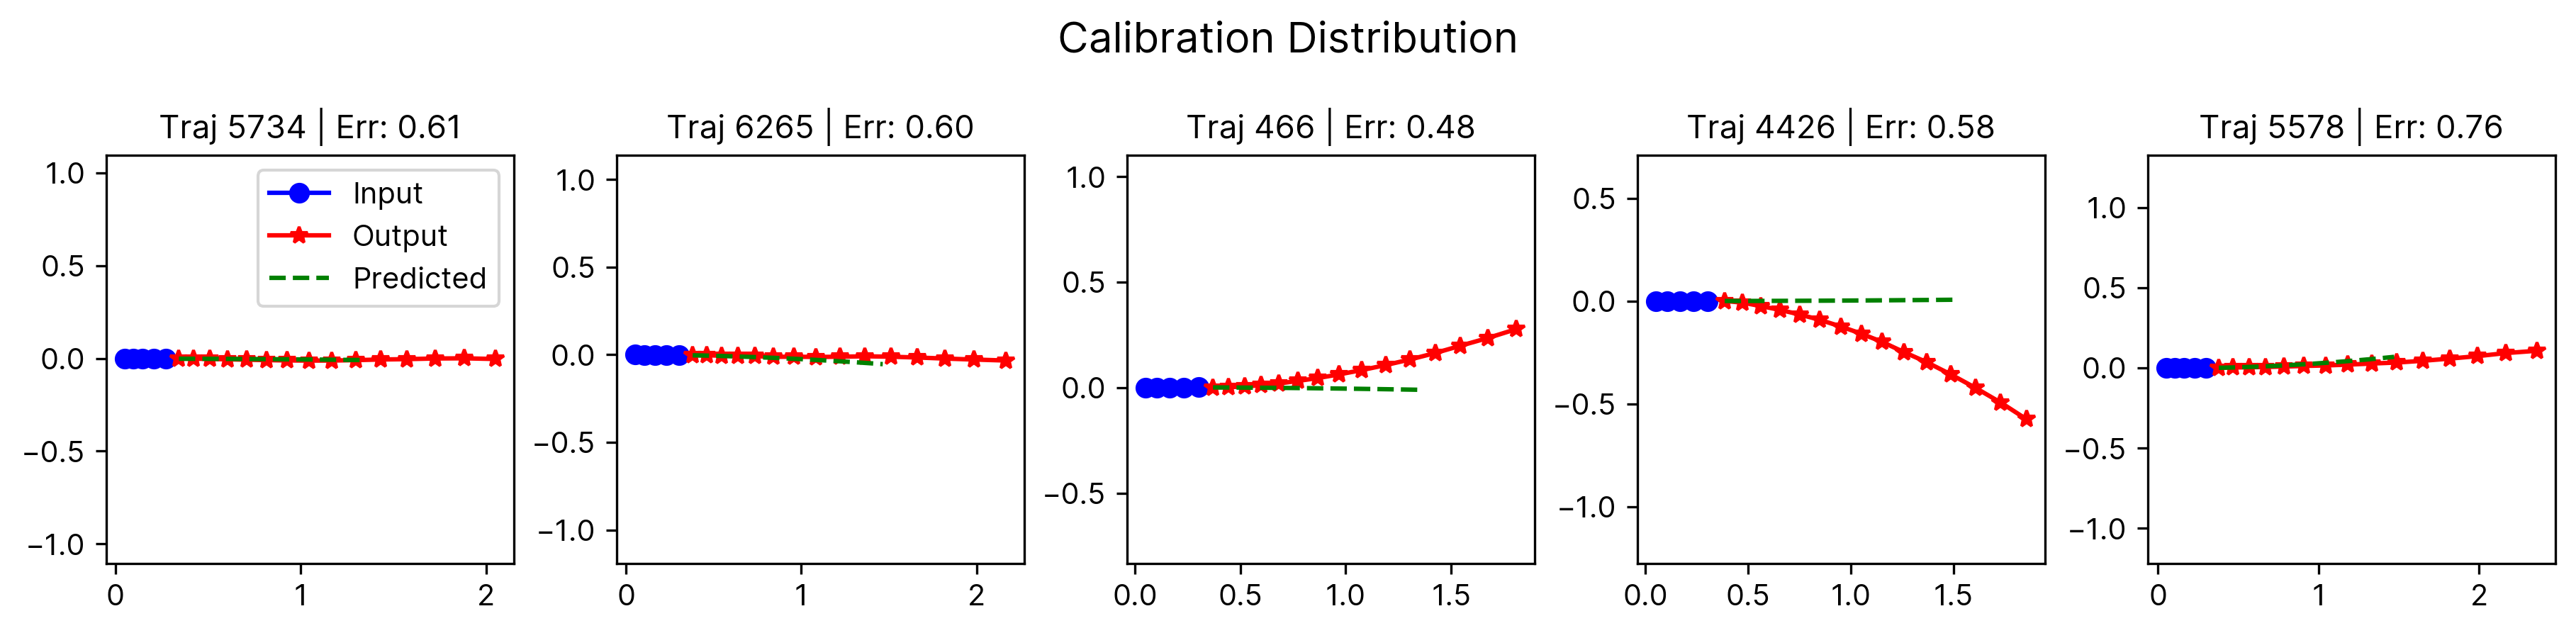

In [6]:
INDEX = np.random.choice(env_X.shape[0], 5)
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'bo-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r*-', label='Output')
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--', label='Predicted')
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Calibration Distribution')

In [7]:
env_Y_hat = predictor.predict_batched_trajectories(env_X)
Z_env = env_Y[:,-1,:2] - env_Y_hat[:,-1,:2]
np.random.shuffle(Z_env)

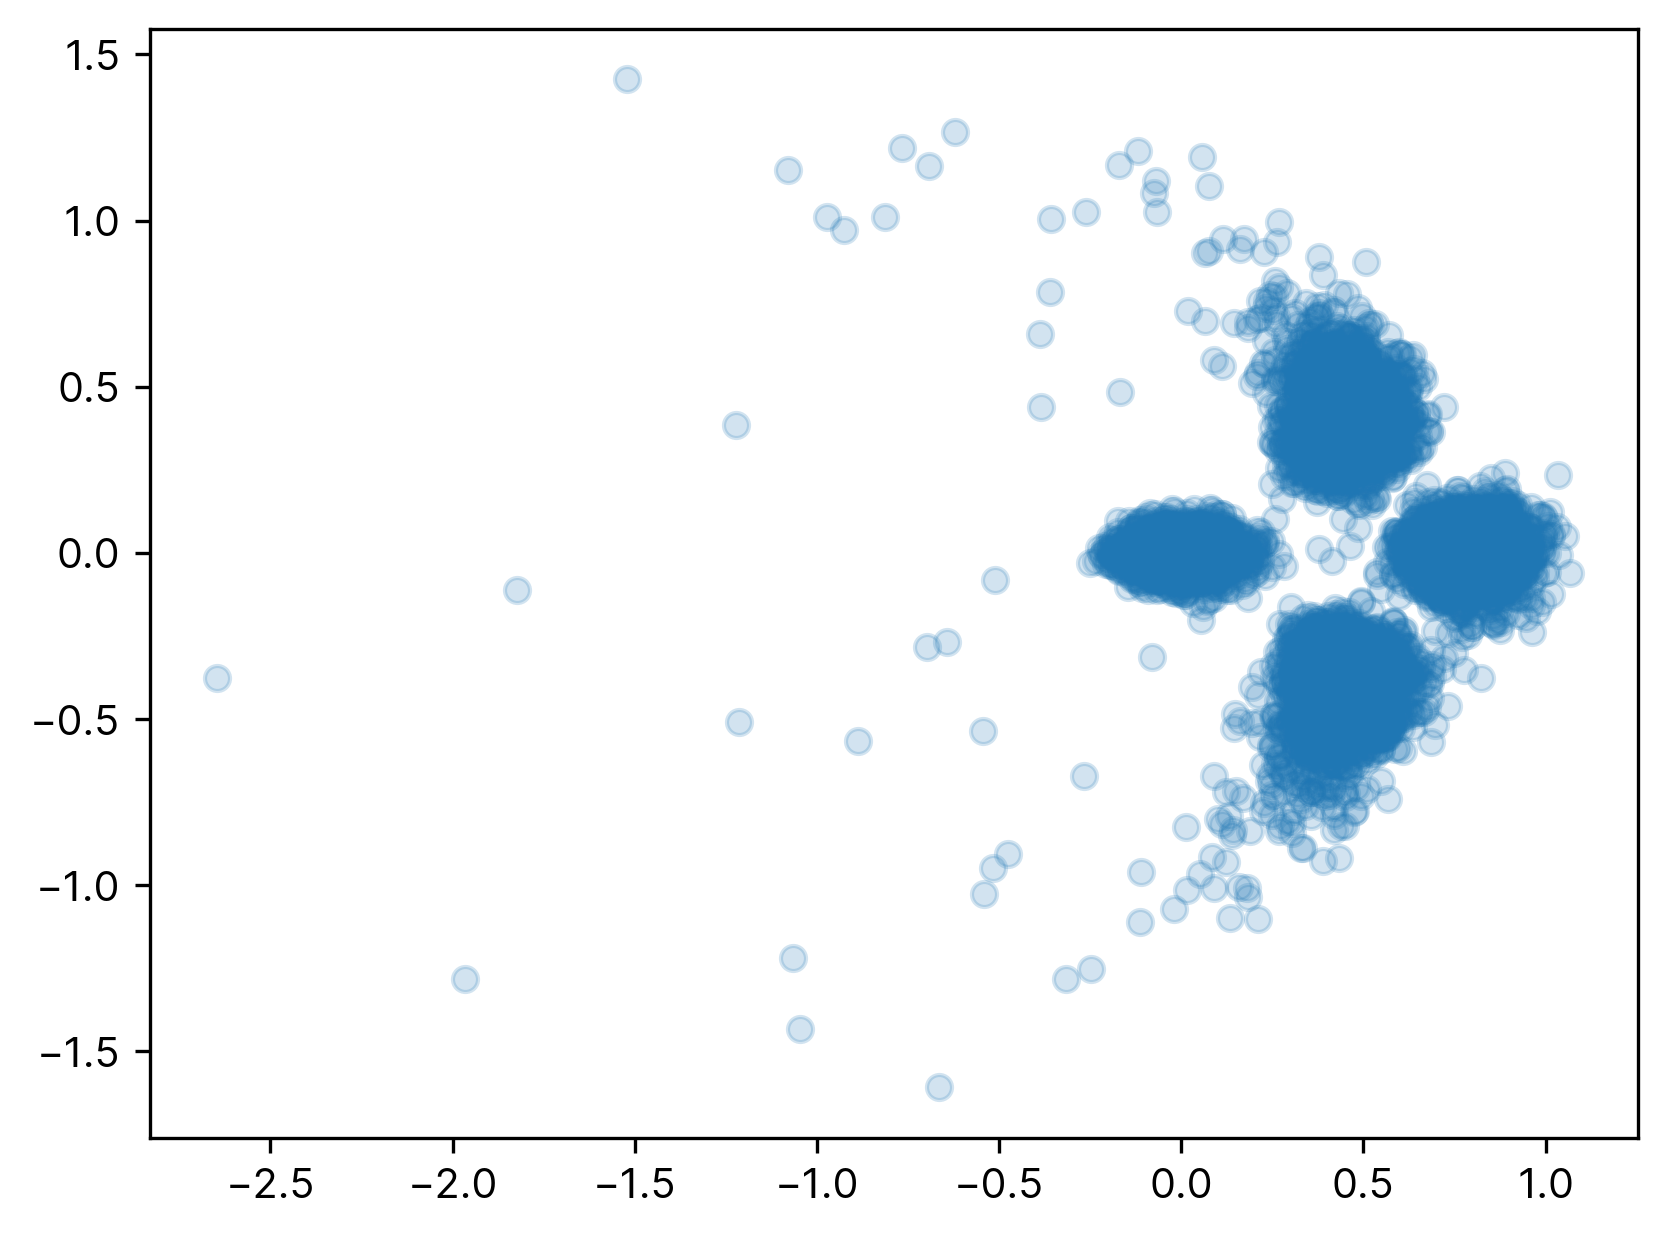

In [8]:
plt.scatter(Z_env[:,0], Z_env[:,1], alpha=0.2)

# Use Parametrized Conformal Regions for Prediction

In [9]:
from conformal_region_designer.density_estimation import KDE
from conformal_region_designer.clustering import MeanShiftClustering
from conformal_region_designer.shapes import HyperRectangle, ConvexHullTemplate, Ellipse
from conformal_region_designer.conformity_optimizer import ConformalRegion

In [10]:
Z_cal_one = Z_env[:Z_env.shape[0]//3]
Z_cal_two = Z_env[Z_env.shape[0]//3:2*(Z_env.shape[0]//3)]
Z_test = Z_env[2*(Z_env.shape[0]//3):]
Z_eval = Z_env[(Z_env.shape[0]//3):]
print(Z_cal_one.shape, Z_cal_two.shape, Z_test.shape)

(3333, 2) (3333, 2) (3334, 2)


## Convex Hull

In [11]:
DELTA = 0.90
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, ConvexHullTemplate, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

Total Weight Sum: 0.9777876940419714


Test Coverage:  0.9007198560287942


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

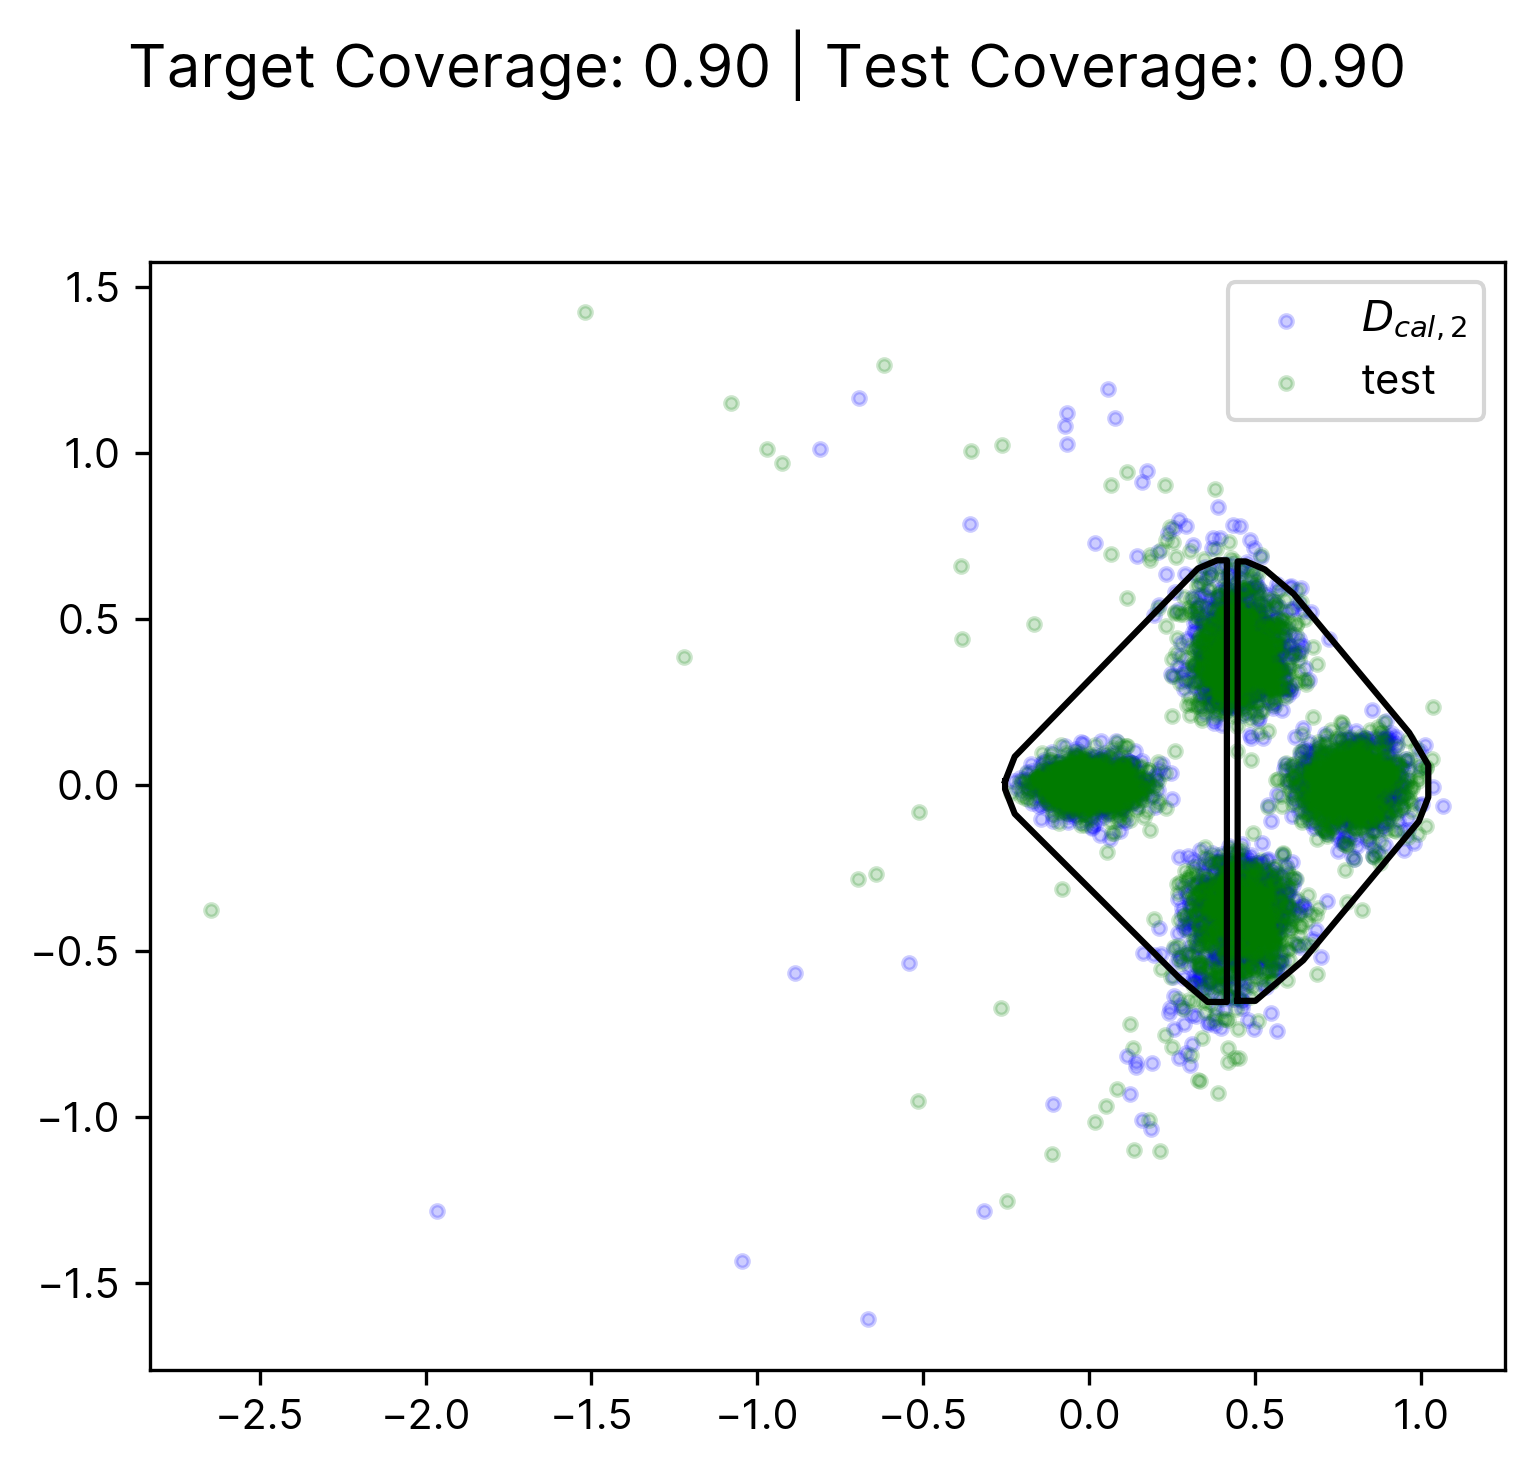

In [12]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Convex Hull Prediction Region for Endpoint')

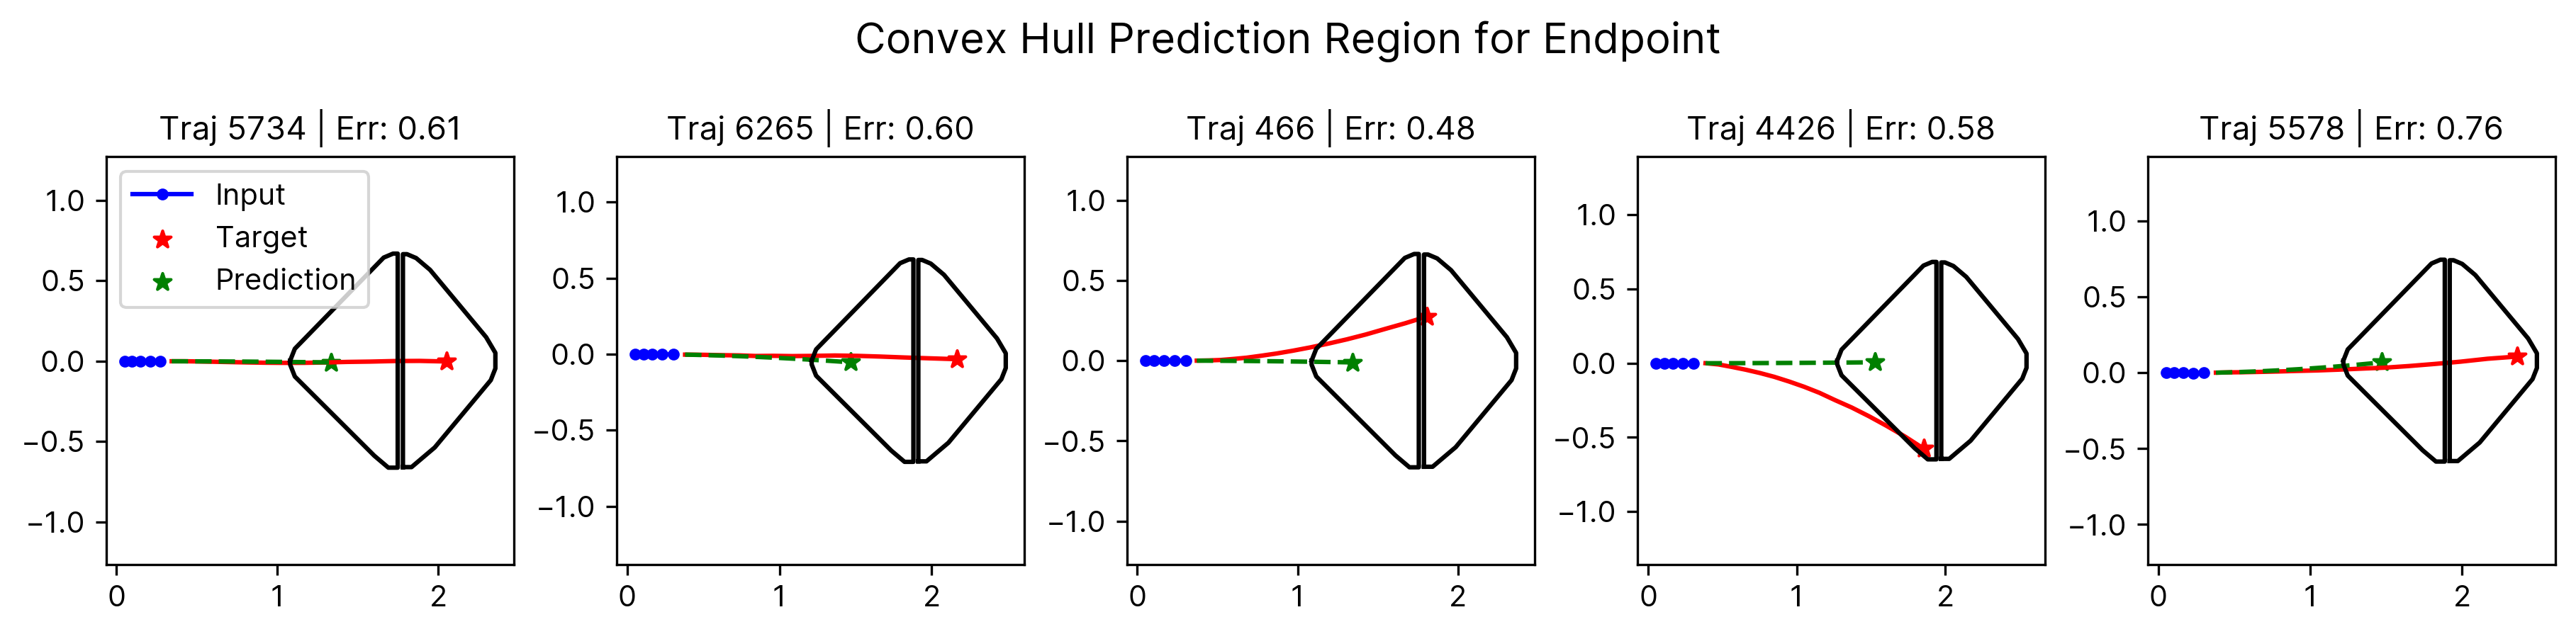

In [13]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Convex Hull Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

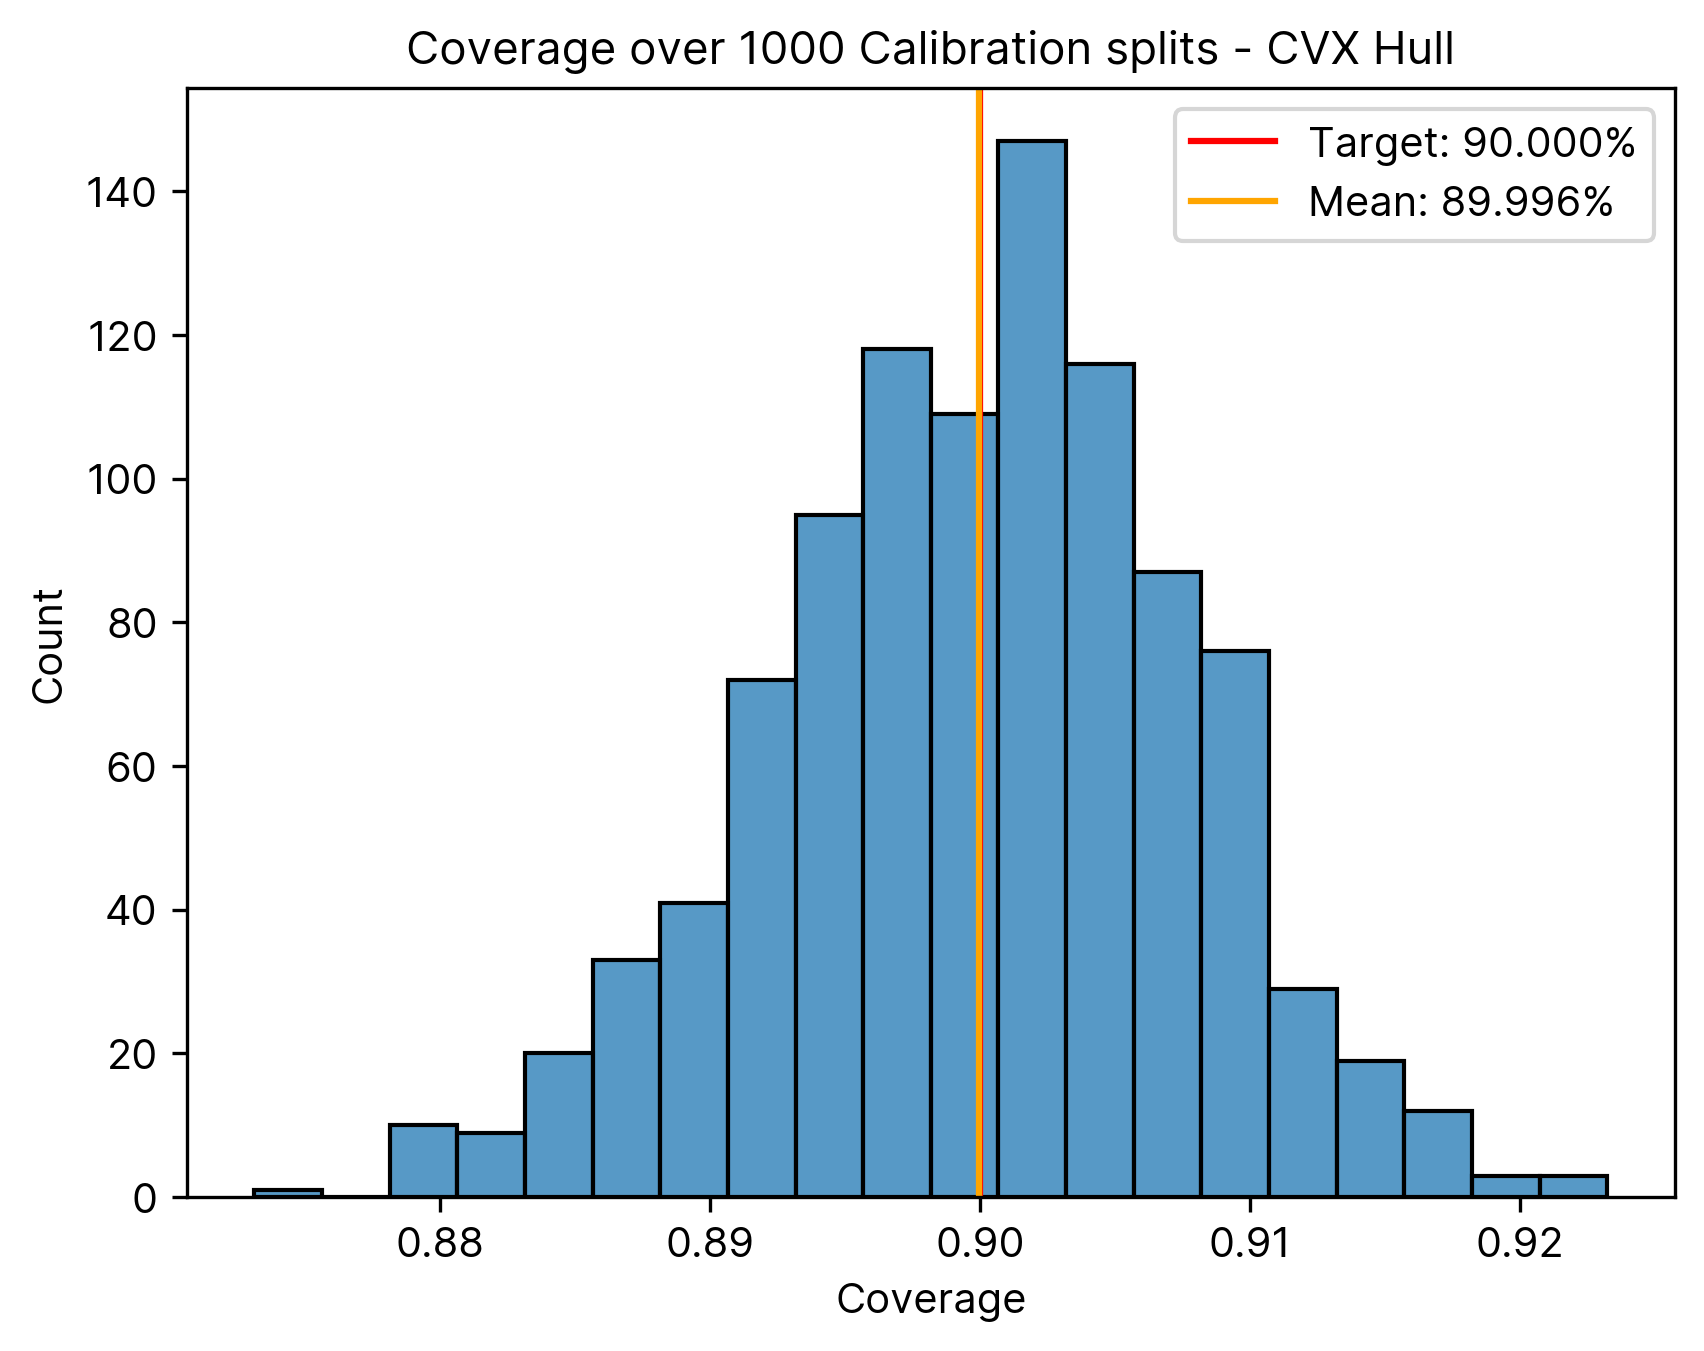

In [14]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - CVX Hull")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Hyperrectangle

In [15]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, HyperRectangle, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)

Total Weight Sum: 0.9777876940419714


Test Coverage:  0.9034193161367726


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

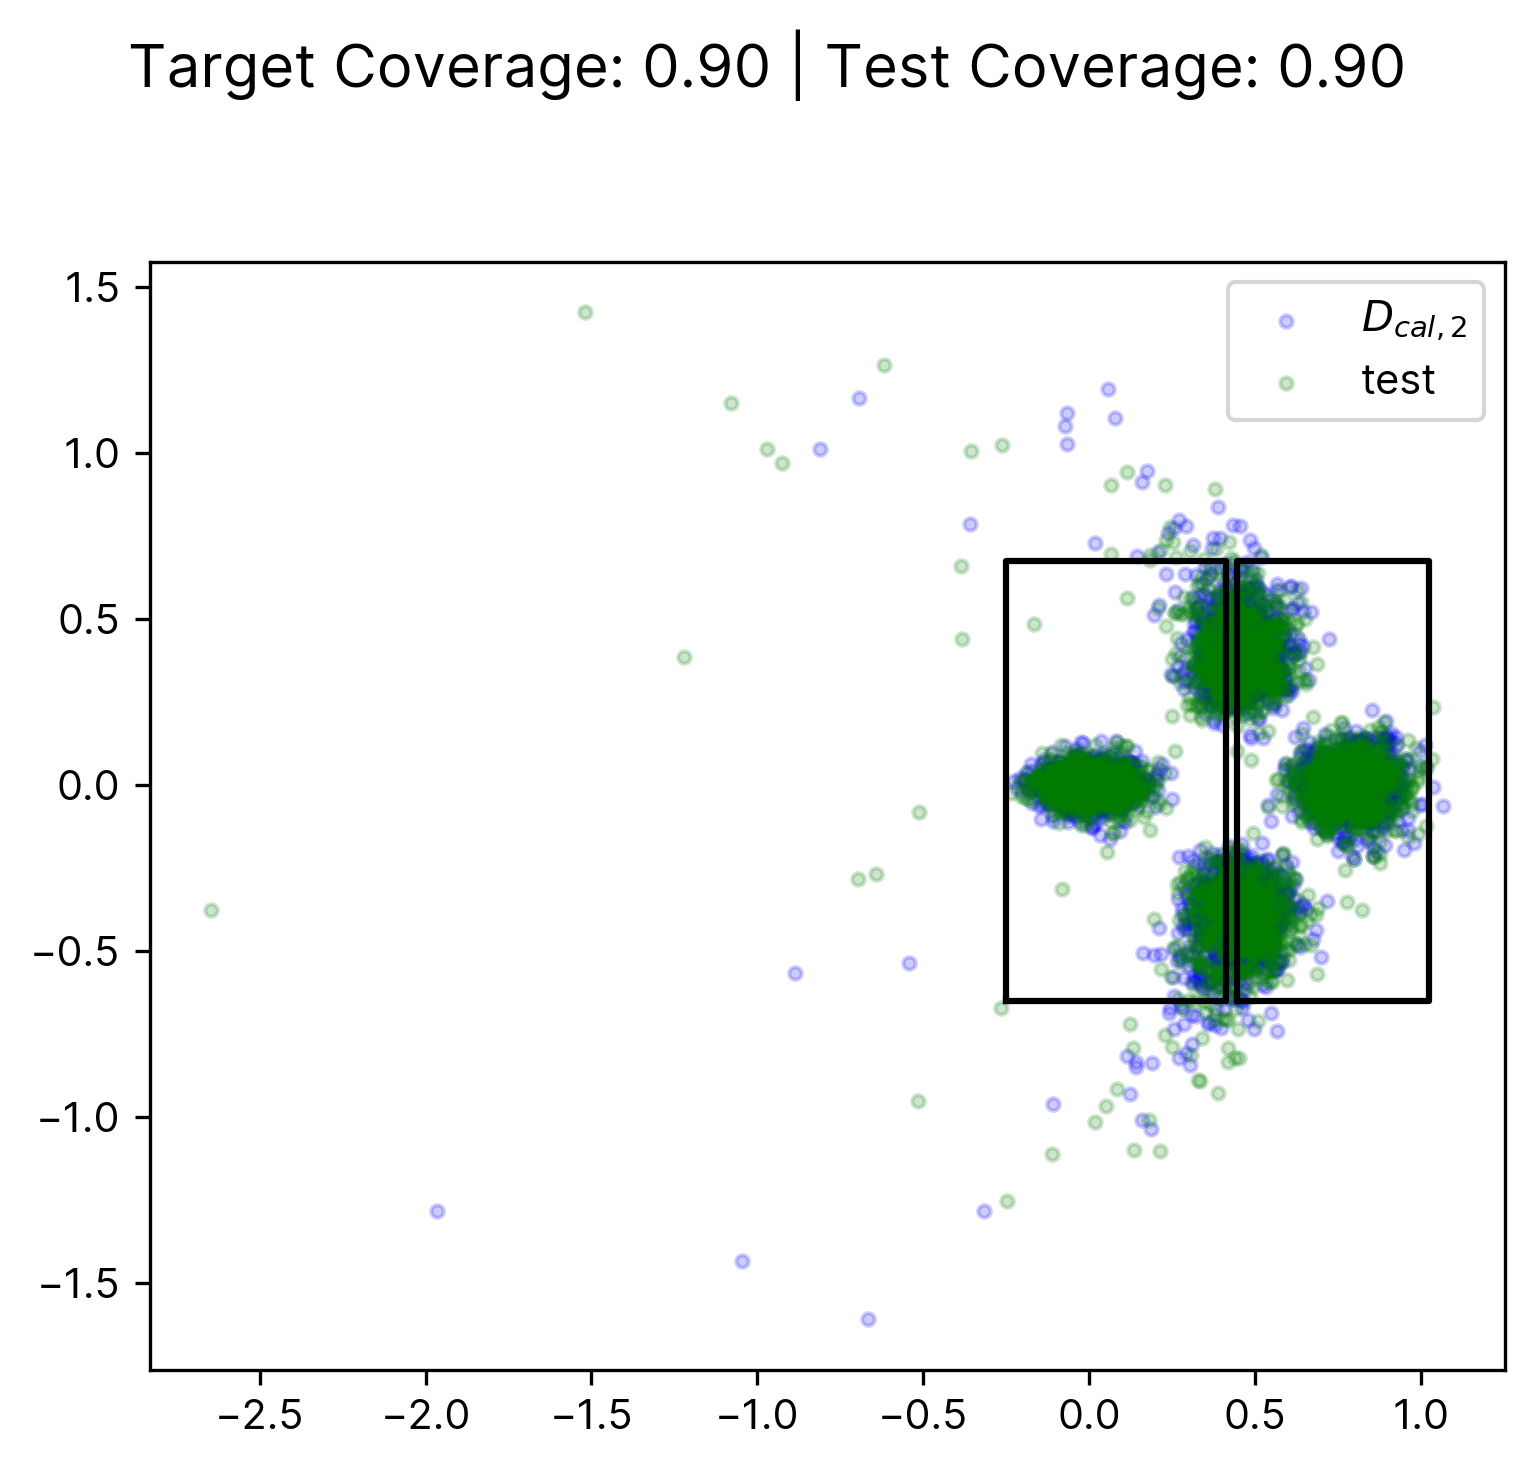

In [16]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Hyperrectangle Prediction Region for Endpoint')

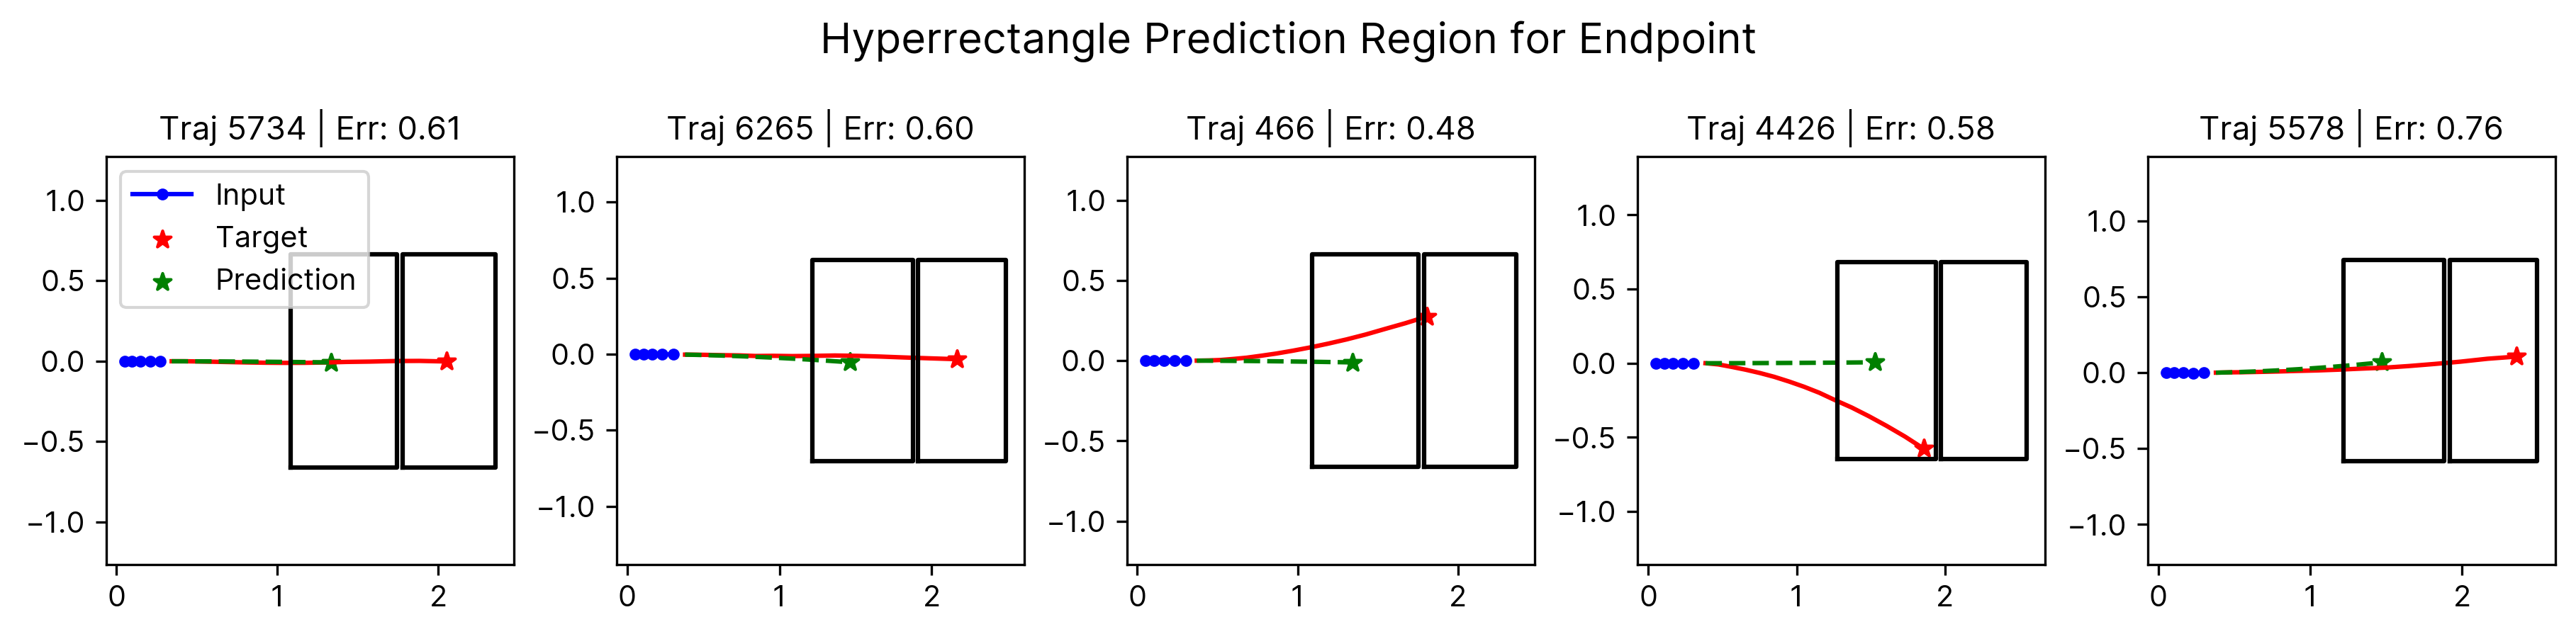

In [17]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Hyperrectangle Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

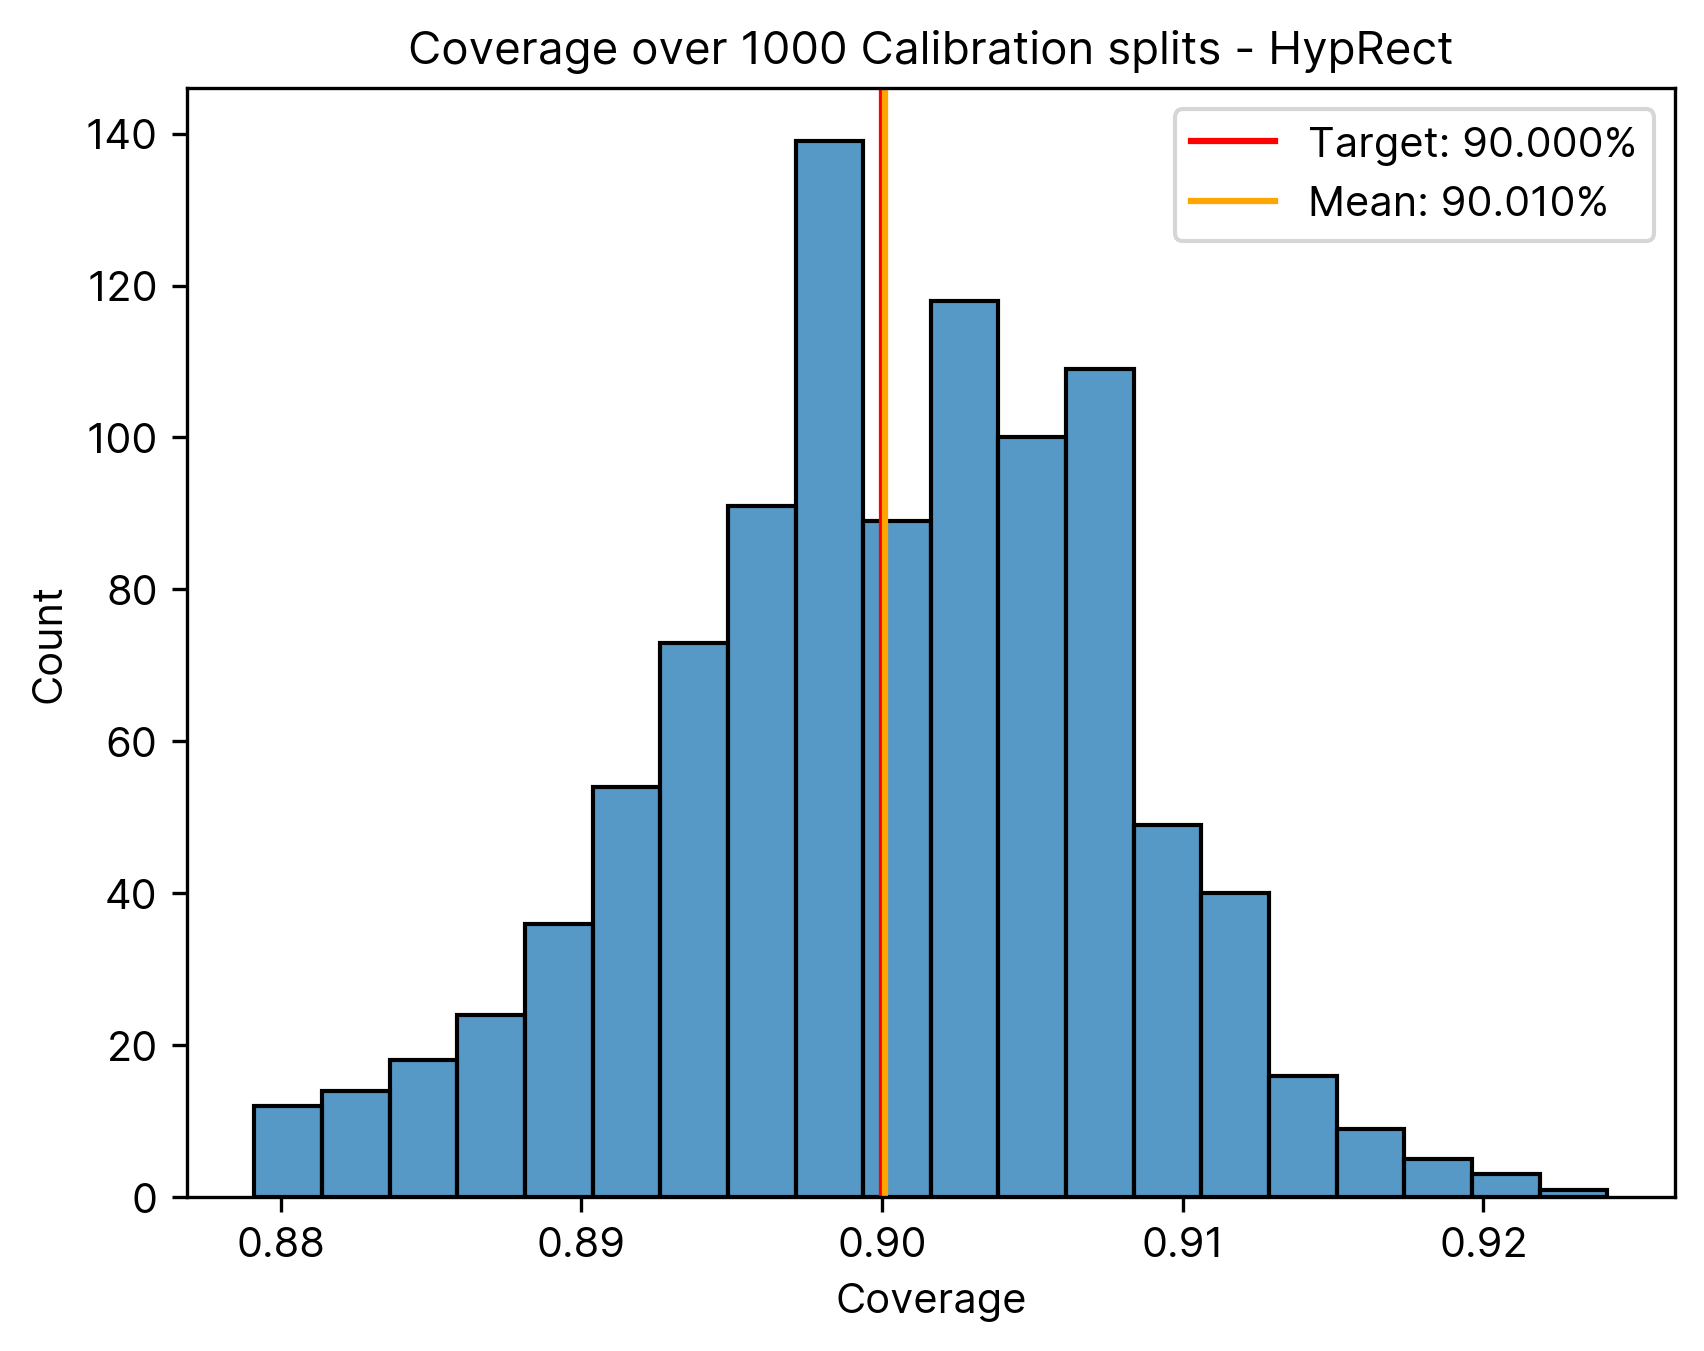

In [18]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - HypRect")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

## Ellipsoid

In [19]:
de = KDE()
cl = MeanShiftClustering()
pcr = ConformalRegion(de, cl, Ellipse, DELTA)
pcr.fit(Z_cal_one)
pcr.conformalize(Z_cal_two)
print(pcr.normalizing_constant)

Total Weight Sum: 0.9777876940419714
(4_w,9)-aCMA-ES (mu_w=2.8,w_1=49%) in dimension 6 (seed=949458, Fri Nov 24 00:17:26 2023)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1      9 1.551901711475423e+00 1.0e+00 9.93e-01  1e+00  1e+00 0:00.0
    2     18 2.500739223583816e+00 1.4e+00 9.24e-01  9e-01  1e+00 0:00.1
    3     27 3.489133053827859e+00 1.5e+00 9.03e-01  8e-01  9e-01 0:00.1
   90    810 2.981422744529811e-01 9.3e+01 7.96e-03  9e-04  1e-02 0:03.1
  100    900 2.981319723694260e-01 1.7e+02 6.18e-03  7e-04  8e-03 0:03.5
  200   1800 2.980706278580180e-01 7.2e+03 1.08e-04  5e-07  2e-04 0:06.9
NOTE (module=cma, iteration=288):  
condition in coordinate system exceeded 1.0e+08, rescaled to 1.0e+00, 
condition changed from 2.4e+10 to 1.2e+09
  300   2700 2.980705581687214e-01 7.1e+04 6.06e-07  8e-11  1e-06 0:10.3
  352   3168 2.980705581191651e-01 3.5e+05 1.79e-07  7e-12  3e-07 0:12.1
termination on tolfun=1e-11 (Fri Nov 24 00:17:39 2023)
final/besteve

/usr/local/lib/python3.10/site-packages/cma/utilities/utils.py:343: UserWarning: 
        geno-pheno transformation introduced based on the
        current covariance matrix with condition 1.0e+12 -> 1.0e+00,
        injected solutions become "invalid" in this iteration (class=CMAEvolutionStrategy method=alleviate_conditioning iteration=300)
  warnings.warn(msg + ' (' +


  346   3114 3.423402855583851e-01 1.2e+01 8.22e-07  5e-07  1e-06 0:09.8
termination on tolfun=1e-11 (Fri Nov 24 00:17:49 2023)
final/bestever f-value = 3.423403e-01 3.423403e-01 after 3115/3115 evaluations
incumbent solution: [-1.8678455147135082, -1.912597276069505, 3.318451311332865, -1.1036276570362133, 0.19182094149414297, 0.006934318267445505]
std deviation: [8.066309784613646e-07, 8.599755922303903e-07, 6.328261062746278e-07, 1.1256953446758922e-06, 1.0215478376999864e-06, 5.099161581543995e-07]
[array([[14.50096597, -0.0898984 ],
       [-0.0898984 ,  4.87602235]])]
[array([0.19182094, 0.00693432])]
Soln time: 10.067649841308594
[4.27715094e-10 1.00000000e+00]


Test Coverage:  0.8962207558488302


Text(0.5, 0.98, 'Target Coverage: 0.90 | Test Coverage: 0.90')

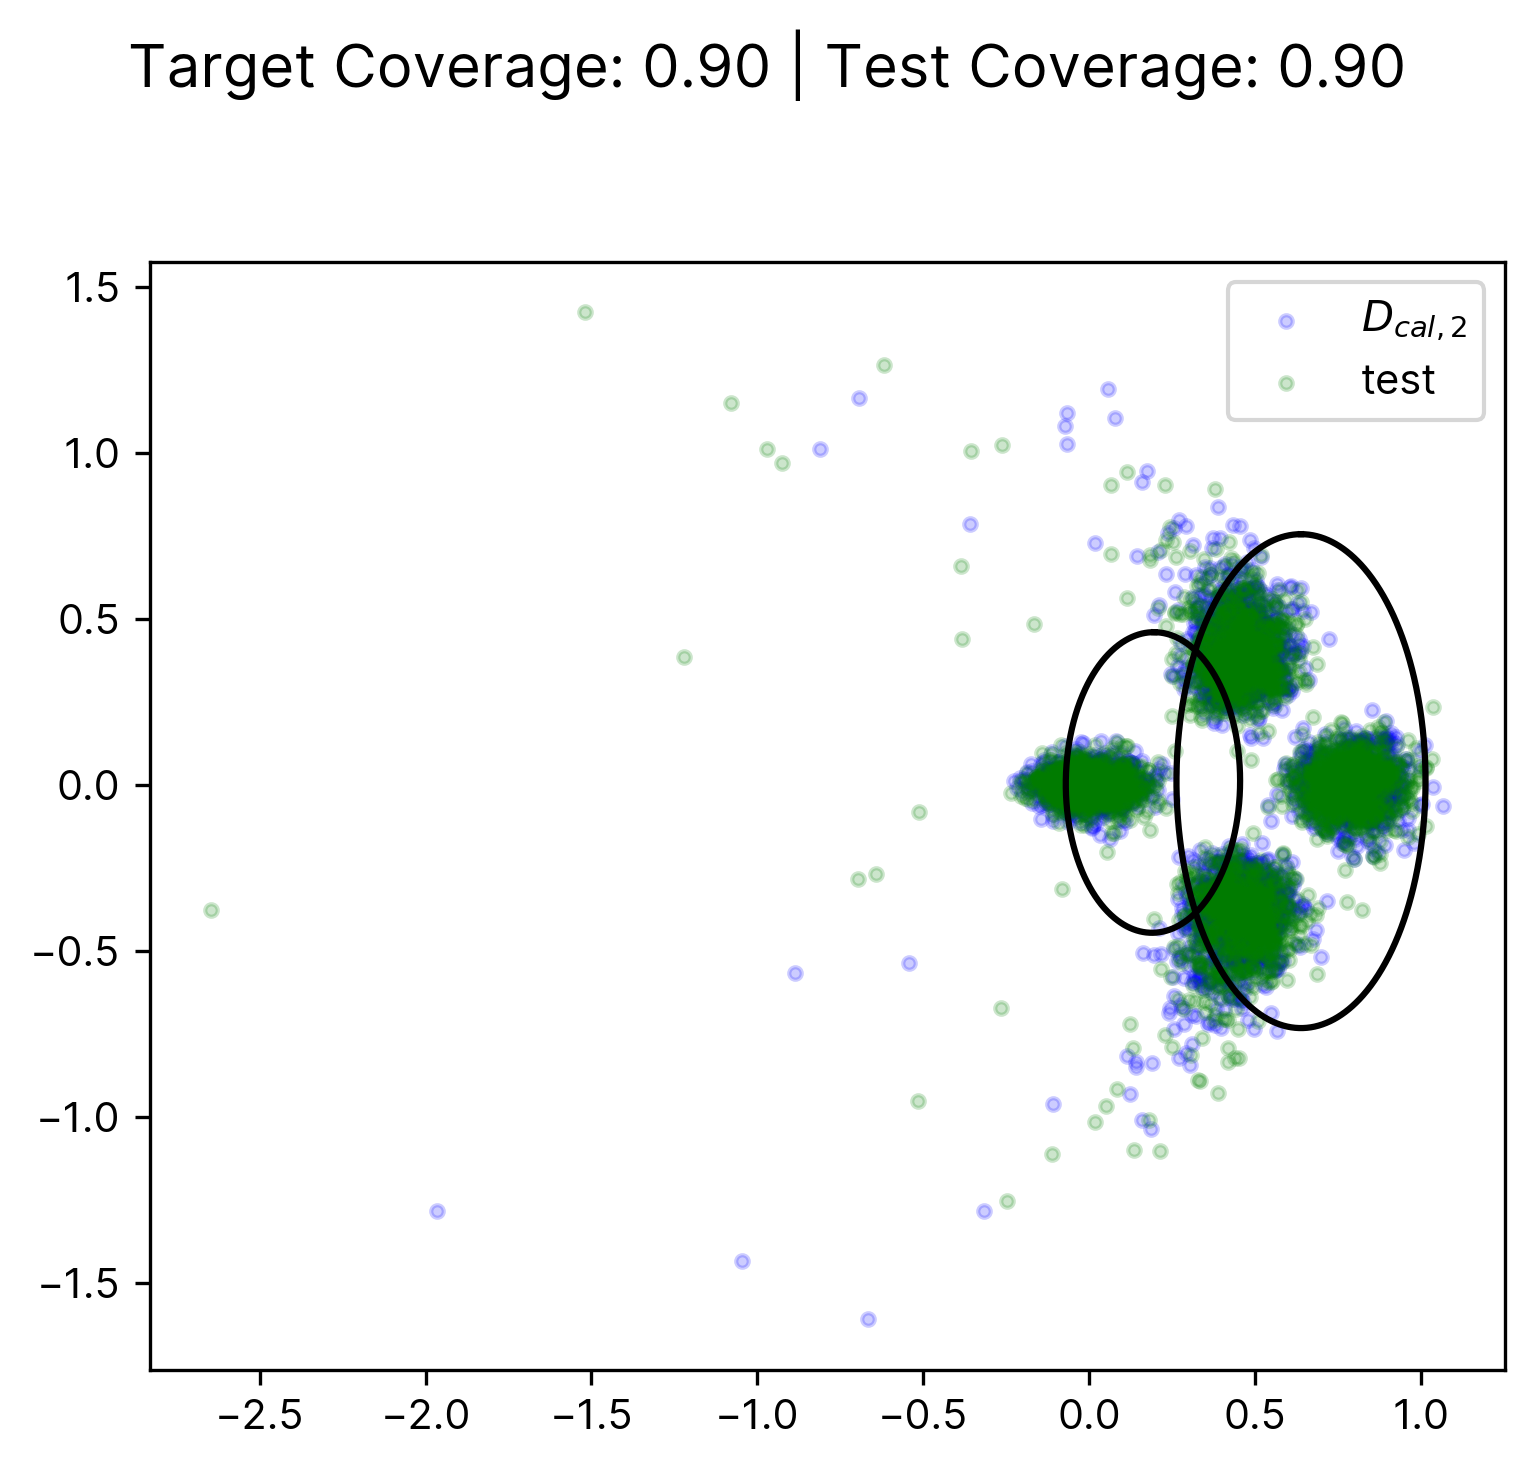

In [20]:
scores = pcr.calculate_scores(Z_test)
coverage = np.sum(scores < 0) / len(scores)
print("Test Coverage: ", coverage)

fig, ax = plt.subplots(constrained_layout=True, figsize=(5, 5), dpi=300)
#ax.scatter(Z_cal_one[:, 0], Z_cal_one[:, 1], color="red", marker=".", label="$D_{cal,1}$")
ax.scatter(Z_cal_two[:, 0], Z_cal_two[:, 1], color="blue", marker=".", label="$D_{cal,2}$", alpha=0.2)
ax.scatter(Z_test[:, 0], Z_test[:, 1], color="green", marker=".", label="test", alpha=0.2)
ax.set_aspect("equal")
for shape_template in pcr.shapes:
    shape_template.plot(ax)
ax.legend()
fig.suptitle(f'Target Coverage: {DELTA:.2f} | Test Coverage: {coverage:.2f}')


Text(0.5, 0.98, 'Ellipsoid Prediction Region for Endpoint')

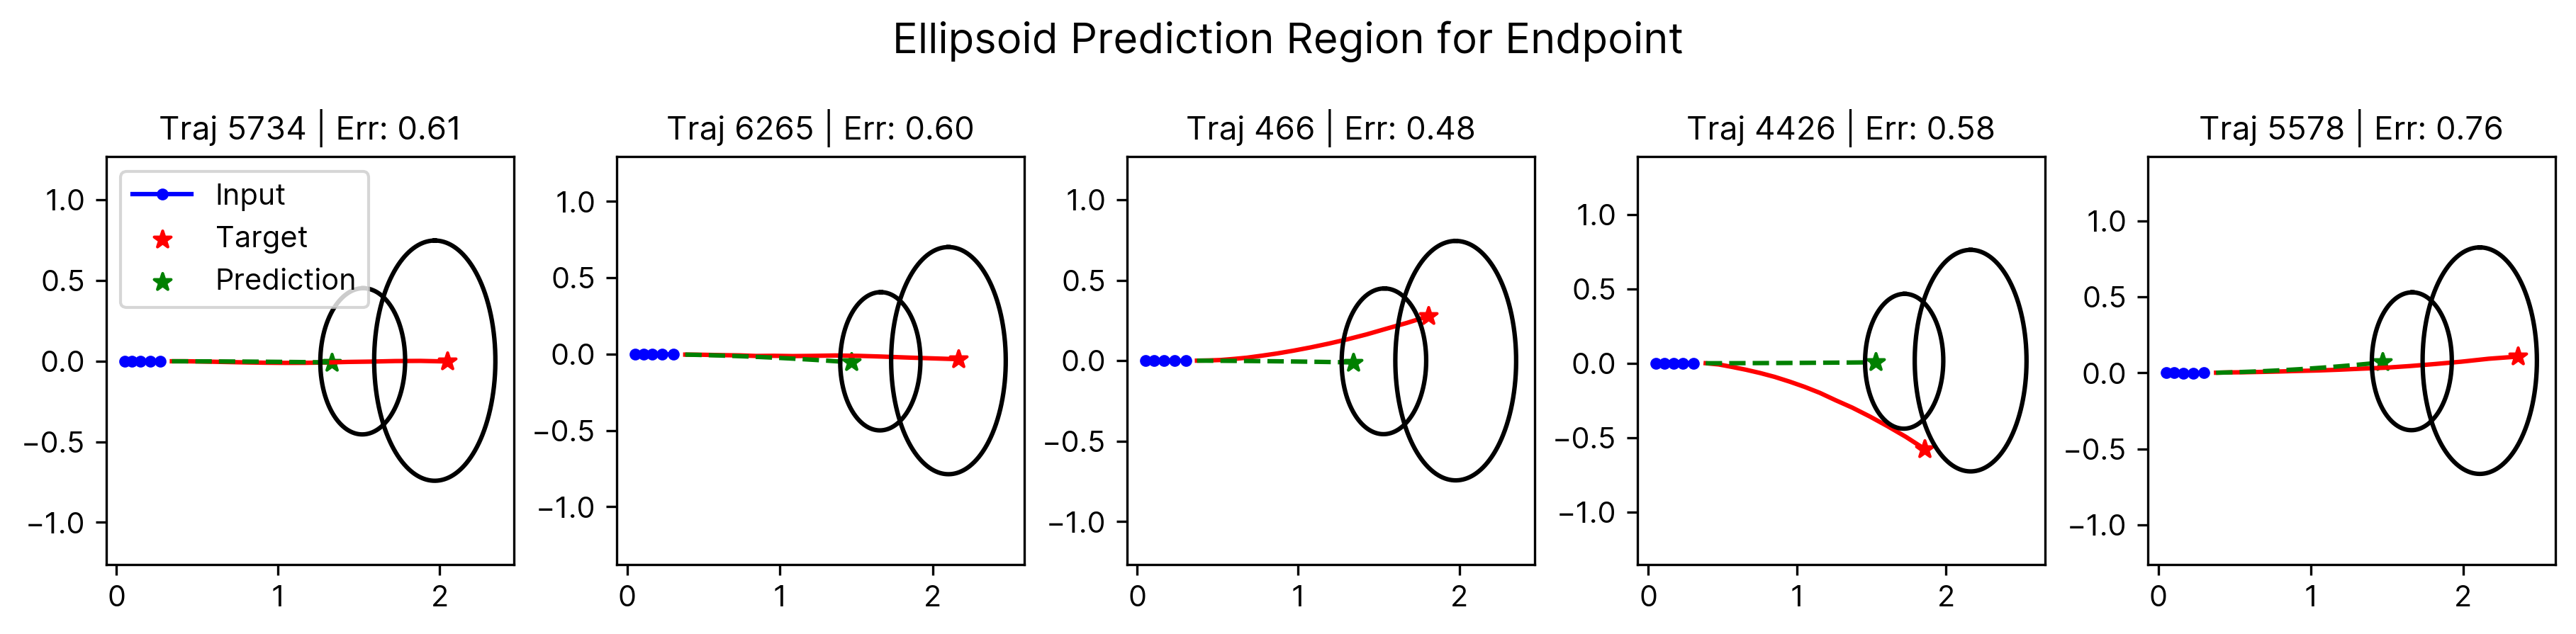

In [21]:
fig, axs = plt.subplots(1, 5, figsize=(12, 3), dpi=300, constrained_layout=True)
for i, ax in enumerate(axs.flat):
    prediction = predictor.predict_trajectory(env_X[INDEX[i]])
    ax.plot(env_X[INDEX[i], :, 0], env_X[INDEX[i], :, 1], 'b.-', label='Input')
    ax.plot(env_Y[INDEX[i], :, 0], env_Y[INDEX[i], :, 1], 'r-')
    ax.scatter(env_Y[INDEX[i], -1, 0], env_Y[INDEX[i], -1, 1], color='r', marker='*', label='Target')
    error = np.linalg.norm(prediction - env_Y[INDEX[i]], axis=1)
    ax.plot(prediction[:, 0], prediction[:, 1], 'g--')
    ax.scatter(prediction[-1, 0], prediction[-1, 1], color='g', marker='*', label='Prediction')
    for shape_template in pcr.shapes:
        shape_template.plot(ax, offset_coords=prediction[-1])
    ax.set_title(f'Traj {INDEX[i]} | Err: {error.mean():.2f}')
    set_square_aspect_ratio(ax)
axs.flat[0].legend()
fig.suptitle('Ellipsoid Prediction Region for Endpoint')

  0%|          | 0/1000 [00:00<?, ?it/s]

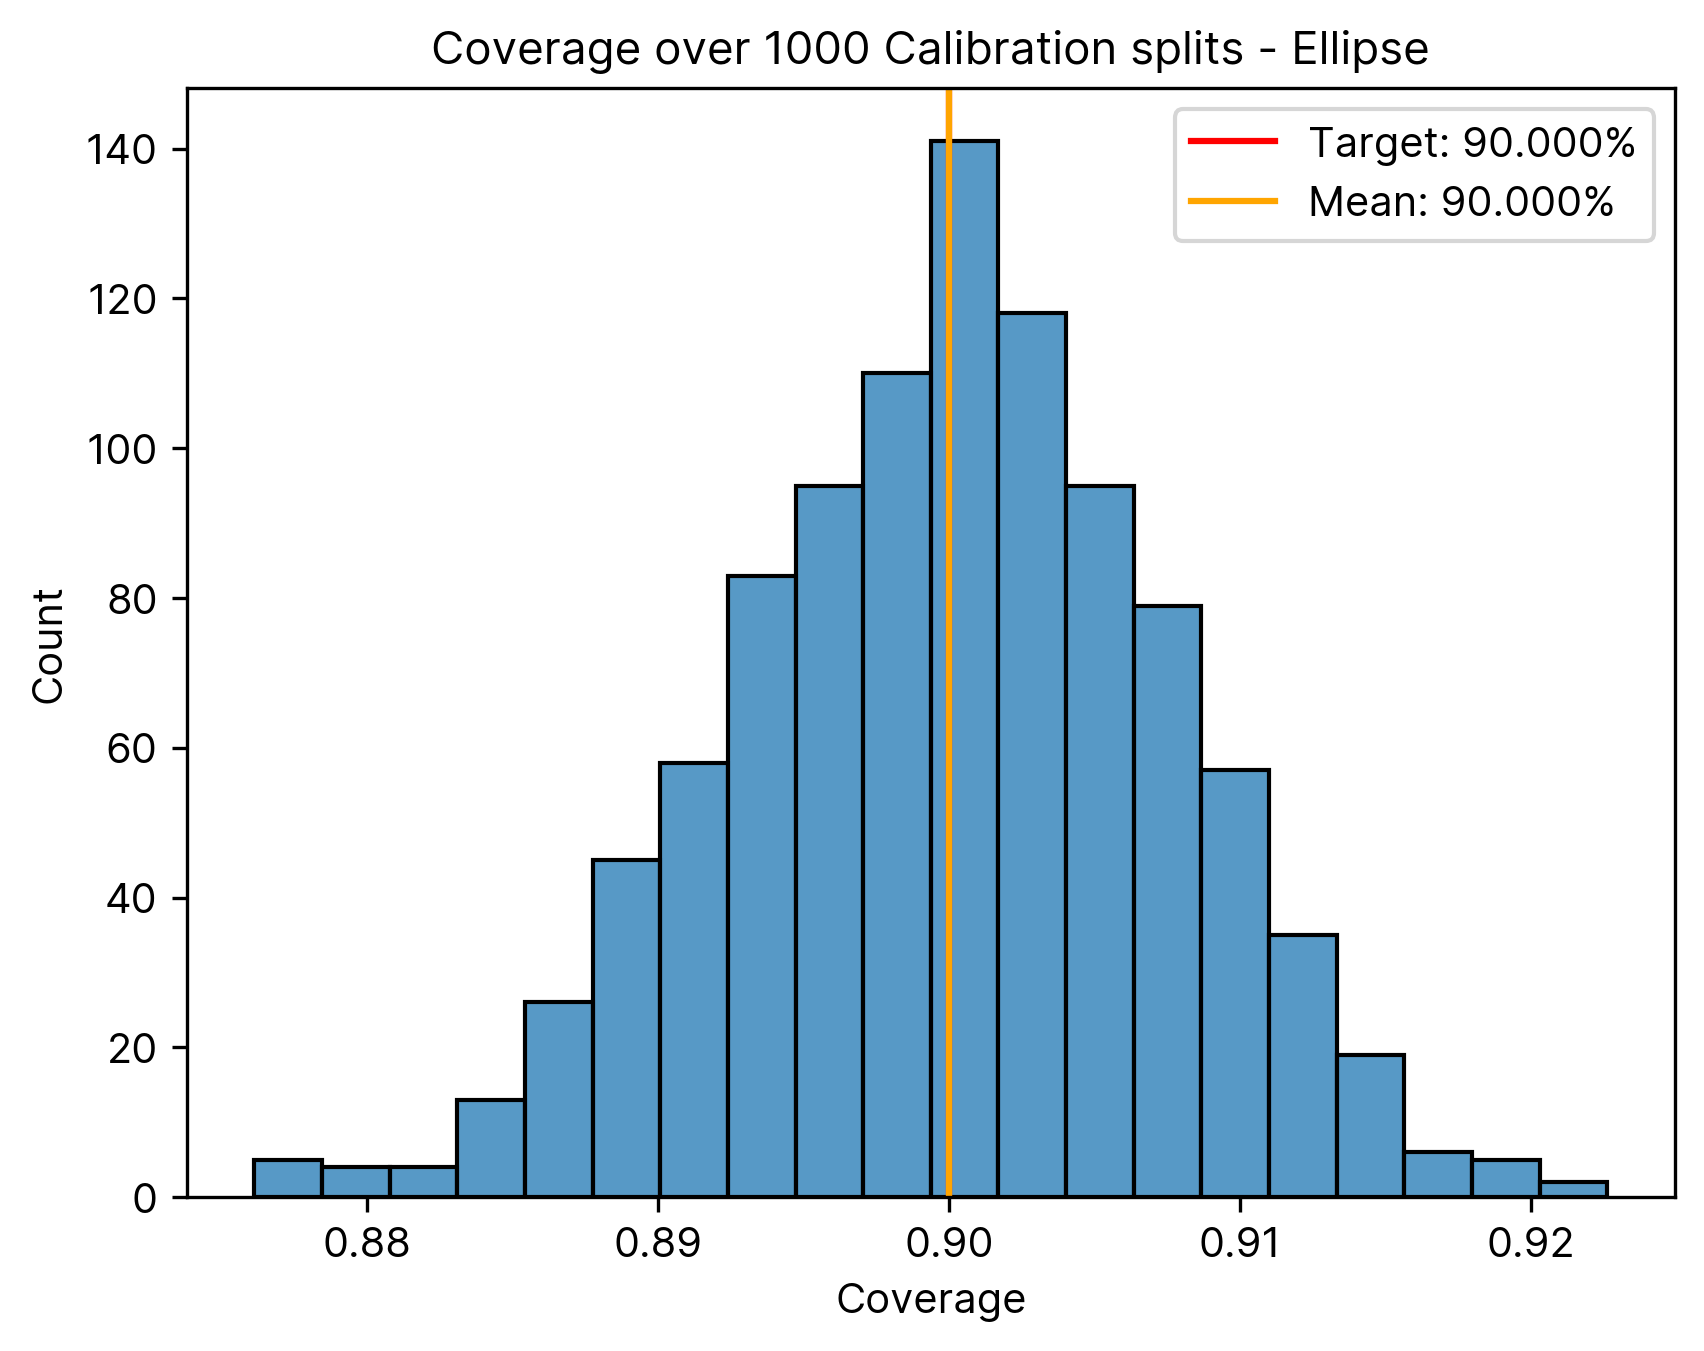

In [22]:
coverages = shuffle_split_testing(pcr, Z_eval, 1000, 0.5, 42)
sns.histplot(coverages, bins=20)
plt.axvline(x=DELTA, color="red", label=f"Target: {DELTA:.3%}")
plt.axvline(x=np.mean(coverages), color="orange", label=f"Mean: {np.mean(coverages):.3%}")
plt.title("Coverage over 1000 Calibration splits - Ellipse")
plt.xlabel("Coverage")
plt.ylabel("Count")
plt.legend()

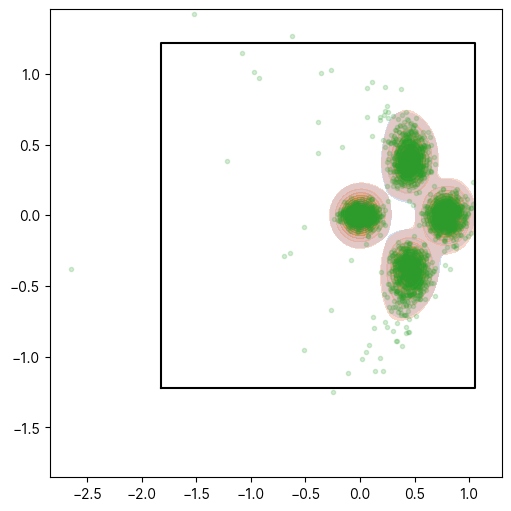

In [23]:
import seaborn as sns
fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=100, constrained_layout=True)
sns.kdeplot(x=Z_cal_one[:,0], y=Z_cal_one[:, 1], fill=True, ax=ax, label='Calibration Set 1', alpha=0.5)
sns.kdeplot(x=Z_cal_two[:,0], y=Z_cal_two[:, 1], fill=True, ax=ax, label='Calibration Set 2', alpha=0.5)
plt.scatter(Z_test[:,0], Z_test[:,1], label='Test Set', alpha=0.2, marker='.')
# Plot the density estimator min and max
ax.plot(
    [de.min[0], de.min[0], de.max[0], de.max[0], de.min[0]],
    [de.min[1], de.max[1], de.max[1], de.min[1], de.min[1]],
    color="black",
)